# Regresija: Predviđanje potrošnje goriva 

U problemu regresije, cilj je izvršiti predikciju kontinualne vrednosti
poput cene proizvoda ili visine osobe. U ovom primeru ćemo videti
kako se neuronske mreže mogu koristiti za rešavanje problema
regresije, a za te potrebe ćemo koristiti skup podataka
[Auto MPG](https://archive.ics.uci.edu/ml/datasets/auto+mpg) koji ima
podatke o potrošnji goriva za automobile iz perida 1970-1980.

In [1]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.8.2


Preuzimanje podataka

In [2]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

'/root/.keras/datasets/auto-mpg.data'

Potom možemo učitati podatke koristeći `pandas` biblioteku za rad
sa tabelarnim podacima.

Od vas se ne očekuje duboko poznavanje biblioteke
`pandas` već samo nekoliko elementarnih transformacija koje će biti prikazane.
U ispitnim zadacima će podaci biti učitani (ali ne i pretprocesirani) za vas.

In [3]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


### Sređivanje podataka

Skup sadrži neke podatke koji imaju nedostajuće vrednosti.

In [4]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

Postoje različiti načini da se bori protiv nedostajućih vrednosti
(njihova aproksimacija prosekom ili drugim vrednostima i slično), ali se u ovom
kursu nećemo baviti time. U našem slučaju, izbacićemo vrste (instance) koje
imaju nedostajuće vrednosti.

In [5]:
dataset = dataset.dropna()

SAVET: Ovo je izuzetno korisna transformacija u praksi. Želimo da elemente
kolone zamenimo nekim drugim vrednosti u zavisnosti od mapiranja koje prosledimo.

In [6]:
#dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

Vršimo dummy enkodiranje kategoričke promenljive.

In [7]:
#dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')
#dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


### Podela podataka

Podatke sada želimo da podelimo na
podatke za obučavanje i podatke za testiranje.

Podatke za testiranje ćemo koristiti za finalnu evaluaciju našeg modela.

In [8]:
# Uzimamo 80% podataka kao podatke za obucavanje
train_dataset = dataset.sample(frac=0.8,random_state=0)

# Ostalih 20% koristimo kao podatke za testiranje
test_dataset = dataset.drop(train_dataset.index)

train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
count,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000
mean,5.477707,195.318471,104.869427,2990.251592,15.559236,75.898089,0.178344,0.197452,0.624204
std,1.699788,104.331589,38.096214,843.898596,2.789230,3.675642,0.383413,0.398712,0.485101
min,3.000000,68.000000,46.000000,1649.000000,8.000000,70.000000,0.000000,0.000000,0.000000
25%,4.000000,105.500000,76.250000,2256.500000,13.800000,73.000000,0.000000,0.000000,0.000000
50%,4.000000,151.000000,94.500000,2822.500000,15.500000,76.000000,0.000000,0.000000,1.000000
75%,8.000000,265.750000,128.000000,3608.000000,17.200000,79.000000,0.000000,0.000000,1.000000
max,8.000000,455.000000,225.000000,5140.000000,24.800000,82.000000,1.000000,1.000000,1.000000


Pogledati opšte statistike. Atribut `MPG` ignorišemo jer će nam to biti ciljna
promenljiva.

In [9]:
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


### Izdvajanje ciljne promenljive

Iz podataka izdvajamo ciljnu promenljivu `MPG` ([miles per gallon](https://www.carwow.co.uk/guides/running/what-is-mpg-0255)).

In [10]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')
train_labels.head()

146    28.0
282    22.3
69     12.0
378    38.0
331    33.8
Name: MPG, dtype: float64

In [11]:
test_labels.head()

9     15.0
25    10.0
28     9.0
31    25.0
33    19.0
Name: MPG, dtype: float64

### Standardizacija podataka

Naši podaci su na različitim skalama pa ima smisla izvršiti njihovu
standardizaciju. Model može da radi i bez ovoga ali se otežava njegova
optimizacija kao i uvodi zavisnost o različitim skalama merenja.

In [12]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

VAŽNO: Primetite da prosek i standardnu devijaciju koristimo iz skupa
za obučavanje i kada vršimo standardizaciju podataka za trening 
**i** testiranje. Ovo je važno jer ne želimo da informacije iz skupa
podataka za testiranje koristimo na bilo koji način prilikom obučavanja
modela jer time uvodimo pristrasnost koja vodi preprilagođavanju.

## Regresioni model

### Definicija modela

Vreme je da definišemo naš model. Koristićemo `Sequential` model
koji će predstavljati jednu neuronsku mrežu sa propagacijom unapred.
Na izlazu ove mreže će biti neuron koji će davati ocenu atributa
`MPG`.

Kao funkciju greške koristićemo srednje-kvadratnu grešku
(eng. mean squared error).

Osim `Adam` optimizatora postoje razni drugi. Više o ovim stvarima na kursu
*Mašinsko učenje* na master studijama. Radi ilustracije, ovde će biti
korišćen `RMSprop` optimizator.

In [13]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_dim = normed_train_data.shape[1]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [14]:
model = build_model()

Možemo isprobati model. Uzećemo podskup od 10 primera iz skupa za obučavanje
i propustiti ih kroz mrežu.


In [15]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.36990806],
       [-0.09745099],
       [-0.02965406],
       [-0.12800455],
       [ 0.3401093 ],
       [ 0.05247471],
       [ 0.3459404 ],
       [ 0.310038  ],
       [ 0.00039633],
       [ 0.2964378 ]], dtype=float32)

In [16]:
example_result.shape

(10, 1)

### Obučavanje modela

Skup za obučavanje ćemo podeliti na dva nova skupa, jedan će biti skup
na kome će se zapravo vršiti obučavanje (80% originalnog skupa za obučavanje),
a validacioni skup ćemo koristiti da na kraju svake epohe evaluiramo
koliko je dobar naš model.

Obučavaćemo model 100
 epoha i čuvaćemo tačnost na podacima za
obučavanje i validaciju tokom treninga. Funkcija `fit` vraća
objekat koji sadrži neophodne podatke.


In [17]:
EPOCHS = 100

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2)

Epoch 1/100
8/8 [==============================] - 1s 48ms/step - loss: 565.7773 - mae: 22.5500 - mse: 565.7773 - val_loss: 554.4411 - val_mae: 22.2954 - val_mse: 554.4411
Epoch 2/100
8/8 [==============================] - 0s 15ms/step - loss: 515.1789 - mae: 21.4523 - mse: 515.1789 - val_loss: 502.7897 - val_mae: 21.1608 - val_mse: 502.7897
Epoch 3/100
8/8 [==============================] - 0s 11ms/step - loss: 466.0961 - mae: 20.3394 - mse: 466.0961 - val_loss: 446.4532 - val_mae: 19.8404 - val_mse: 446.4532
Epoch 4/100
8/8 [==============================] - 0s 10ms/step - loss: 411.9848 - mae: 19.0177 - mse: 411.9848 - val_loss: 384.8663 - val_mae: 18.2896 - val_mse: 384.8663
Epoch 5/100
8/8 [==============================] - 0s 14ms/step - loss: 354.6589 - mae: 17.5162 - mse: 354.6589 - val_loss: 321.9256 - val_mae: 16.5493 - val_mse: 321.9256
Epoch 6/100
8/8 [==============================] - 0s 9ms/step - loss: 296.0324 - mae: 15.8429 - mse: 296.0324 - val_loss: 259.5166 - val_ma

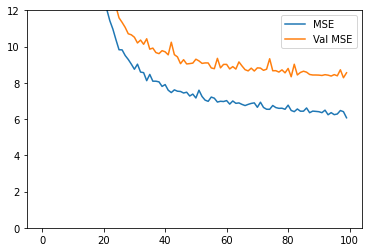

In [18]:
plt.plot(history.epoch, history.history['mse'])
plt.plot(history.epoch, history.history['val_mse'])
plt.ylim([0, 12])
plt.legend(['MSE', 'Val MSE'])
plt.show()

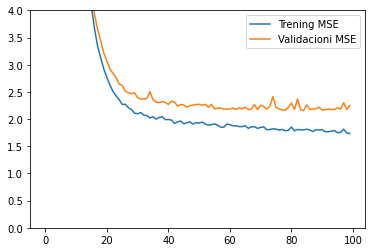

In [19]:
plt.plot(history.epoch, history.history['mae'])
plt.plot(history.epoch, history.history['val_mae'])
plt.ylim([0, 4])
plt.legend(['Trening MSE', 'Validacioni MSE'])
plt.show()

Dobijene podatke možemo vizuelizovati pomoću biblioteke `pandas`.
`DataFrame` je `pandas` tip koji predstavlja tabelarne podatke.

In [20]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

# Uzimamo poslednjih 5 vrsti
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
95,6.243923,1.749683,6.243923,8.454068,2.206064,8.454068,95
96,6.280717,1.754701,6.280717,8.387254,2.181073,8.387254,96
97,6.472411,1.813883,6.472411,8.720399,2.303679,8.720399,97
98,6.407638,1.745342,6.407638,8.282020,2.176103,8.282020,98
99,6.071924,1.734501,6.071924,8.554684,2.250299,8.554684,99


Definisati skup ograničenja koja kad se ispune, obučavanje modela će biti zaustavljeno. Na primer, ukoliko se u `k` uzastopnih epoha ne poboljša vrednost `val_mse` ima smisla zaustaviti obučavanje.

Kako odrediti parametar `k`? U pitanju je sličan problem kao i kako odrediti arhitekturu mreže, optimizator i slično.

In [21]:
model = build_model()

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history = model.fit(normed_train_data, train_labels, 
                    epochs=EPOCHS, validation_split=0.2, verbose=1, 
                    callbacks=[early_stop])

Epoch 1/100
8/8 [==============================] - 2s 98ms/step - loss: 563.6382 - mae: 22.4691 - mse: 563.6382 - val_loss: 549.0650 - val_mae: 22.0845 - val_mse: 549.0650
Epoch 2/100
8/8 [==============================] - 0s 20ms/step - loss: 504.4591 - mae: 21.0921 - mse: 504.4591 - val_loss: 489.6911 - val_mae: 20.6721 - val_mse: 489.6911
Epoch 3/100
8/8 [==============================] - 0s 21ms/step - loss: 448.8254 - mae: 19.7110 - mse: 448.8254 - val_loss: 428.6888 - val_mae: 19.1137 - val_mse: 428.6888
Epoch 4/100
8/8 [==============================] - 0s 11ms/step - loss: 391.8441 - mae: 18.1583 - mse: 391.8441 - val_loss: 367.0181 - val_mae: 17.3804 - val_mse: 367.0181
Epoch 5/100
8/8 [==============================] - 0s 9ms/step - loss: 332.3217 - mae: 16.4355 - mse: 332.3217 - val_loss: 301.8102 - val_mae: 15.4141 - val_mse: 301.8102
Epoch 6/100
8/8 [==============================] - 0s 18ms/step - loss: 271.5844 - mae: 14.5640 - mse: 271.5844 - val_loss: 238.1977 - val_ma

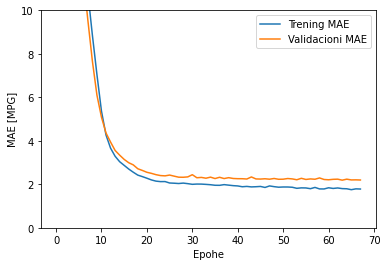

In [22]:
plt.plot(early_history.epoch, early_history.history['mae'])
plt.plot(early_history.epoch, early_history.history['val_mae'])
plt.ylim([0, 10])
plt.legend(['Trening MAE', 'Validacioni MAE'])
plt.xlabel('Epohe')
plt.ylabel('MAE [MPG]')
plt.show()

Graf pokazuje da je na validacionom skupu, prosečna greška oko +/- 2 MPG.
Da li je ovo dobro ili ne, zavisi od mere i slučaja upotrebe koji zavise
od problema do problema.

### Evaluacija modela

Sledeće što ćemo  uraditi je da pogledamo koliko dobro model generalizuje
na podacima za testiranje.

Ovde se stvar malko komplikuje. Treba imati u vidu da smo model do sada
obučavali na podskupu (80%) skupa za obučavanje kako bi imali validacioni skup.
Nema smisla baciti podatke (20% podataka za obučavanje koji su završili kao validacioni podataci), tako da ćemo ponovo
obučiti model, ali sada nam celokupnim podacima za obučavanje, i TAJ
model ćemo koristiti za evaluaciju na test skupu.

Postavlja se pitanje koliko epoha postaviti za obučavanje? Jedan od pristupa je
postaviti broj epoha koji je uzet prilikom ranoh zaustavljanja. U momentu
pisanja ovih materijala, na ovom primeru je to bilo 53.

In [23]:
model = build_model()

early_stop_epochs = 53

final_history = model.fit(normed_train_data, train_labels, 
                    epochs=early_stop_epochs, verbose=1)

Epoch 1/53
10/10 [==============================] - 1s 8ms/step - loss: 576.0864 - mae: 22.7719 - mse: 576.0864
Epoch 2/53
10/10 [==============================] - 0s 4ms/step - loss: 511.3421 - mae: 21.2431 - mse: 511.3421
Epoch 3/53
10/10 [==============================] - 0s 5ms/step - loss: 448.9032 - mae: 19.7082 - mse: 448.9032
Epoch 4/53
10/10 [==============================] - 0s 6ms/step - loss: 380.7449 - mae: 17.9366 - mse: 380.7449
Epoch 5/53
10/10 [==============================] - 0s 5ms/step - loss: 308.5703 - mae: 15.8656 - mse: 308.5703
Epoch 6/53
10/10 [==============================] - 0s 5ms/step - loss: 238.0143 - mae: 13.7171 - mse: 238.0143
Epoch 7/53
10/10 [==============================] - 0s 5ms/step - loss: 174.3161 - mae: 11.5476 - mse: 174.3161
Epoch 8/53
10/10 [==============================] - 0s 8ms/step - loss: 121.8832 - mae: 9.3593 - mse: 121.8832
Epoch 9/53
10/10 [==============================] - 0s 6ms/step - loss: 83.6847 - mae: 7.4086 - mse: 83.6

Konačno, možemo pogledati kako se naš model ponaša na skupu za testiranje.

In [24]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

3/3 - 0s - loss: 6.3974 - mae: 1.9888 - mse: 6.3974 - 256ms/epoch - 85ms/step
Testing set Mean Abs Error:  1.99 MPG


Dobijamo 1.83 MPG srednja apsolutna greška.